In [95]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast

In [2]:
# Load the data
df = pd.read_csv('data/all_securities.csv', header = 0)

In [3]:
# Transform 'Date' column to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [45]:
start_date = '2022-01-01'
end_date_training = '2022-08-31'
start_date_testing= '2022-09-01'
end_date_testing = '2022-09-30'

training_data = df.loc[start_date:end_date_training]
testing_data = df.loc[start_date_testing:end_date_testing]

In [52]:
X_train=training_data[['VTSAX_Close', 'XLK_Close', 'SNP_Close']]
X_test=testing_data[['VTSAX_Close', 'XLK_Close', 'SNP_Close']]
y_train=training_data['DELL_Close']
y_test=testing_data['DELL_Close']

In [53]:
# Fit the linear regression model
model = sm.OLS(y_train, X_train)
results = model.fit()

# Print the summary of the regression results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:             DELL_Close   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.201e+04
Date:                Wed, 17 Apr 2024   Prob (F-statistic):                   6.61e-192
Time:                        17:51:50   Log-Likelihood:                         -439.79
No. Observations:                 167   AIC:                                      885.6
Df Residuals:                     164   BIC:                                      894.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [105]:
# Make predictions on the test set
y_pred_test = results.predict(X_test)

# Calculate MSE on the test set
mse_test = mean_squared_error(y_test, y_pred_test)

# Return MSE on the test set
print("Mean Squared Error on Test Data:", mse_test)

Mean Squared Error on Test Data: 44.69304120411537


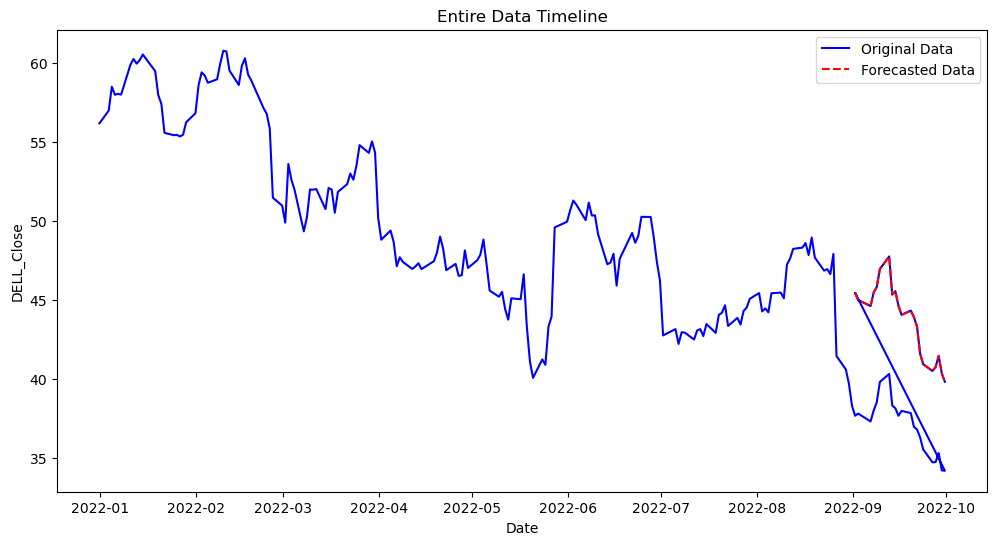

In [106]:
# Combine original and forecasted data for plotting
combined_data = pd.concat([df['DELL_Close'], pd.Series(y_pred_test, index=testing_data.index)], axis=0)

# Plot original and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data, label='Original Data', color='blue')
plt.plot(testing_data.index, y_pred_test, label='Forecasted Data', linestyle='--', color='red')
plt.title('Entire Data Timeline')
plt.xlabel('Date')
plt.ylabel('DELL_Close')
plt.legend()
plt.show()

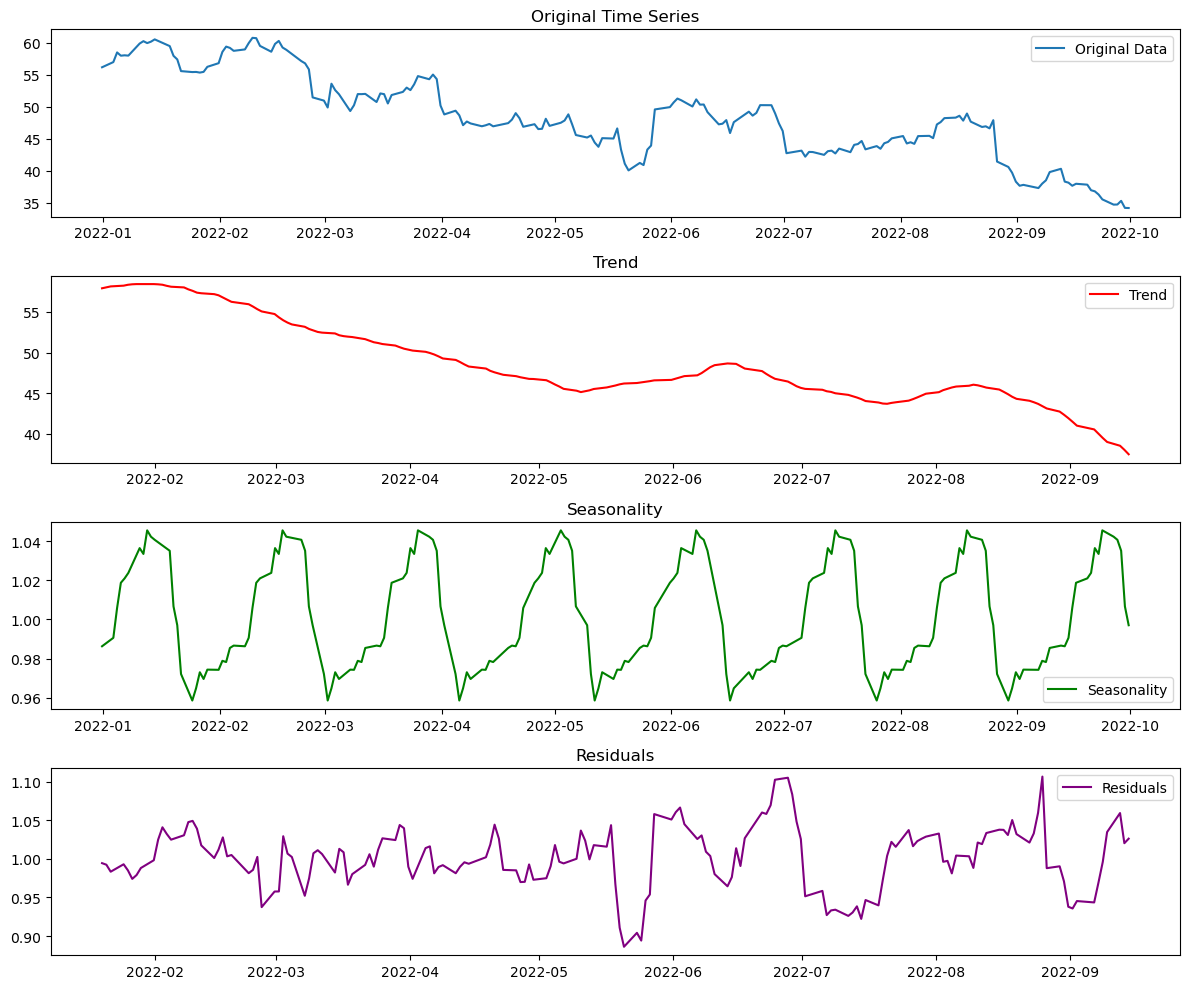

In [77]:

# Decompose the time series into its components
decomposition = seasonal_decompose(df['DELL_Close'], model='multiplitive',period=25)

# Plot the original time series
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(df.index, df['DELL_Close'], label='Original Data')
plt.legend()
plt.title('Original Time Series')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(df.index, decomposition.trend, label='Trend', color='red')
plt.legend()
plt.title('Trend')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(df.index, decomposition.seasonal, label='Seasonality', color='green')
plt.legend()
plt.title('Seasonality')

# Plot the residuals (remainder after removing trend and seasonality)
plt.subplot(4, 1, 4)
plt.plot(df.index, decomposition.resid, label='Residuals', color='purple')
plt.legend()
plt.title('Residuals')

plt.tight_layout()
plt.show()

In [85]:
df.index.freq

In [107]:
# Fit STL model to the original data
stl_model = STL(df['DELL_Close'],period = 20)  
stl_result = stl_model.fit()


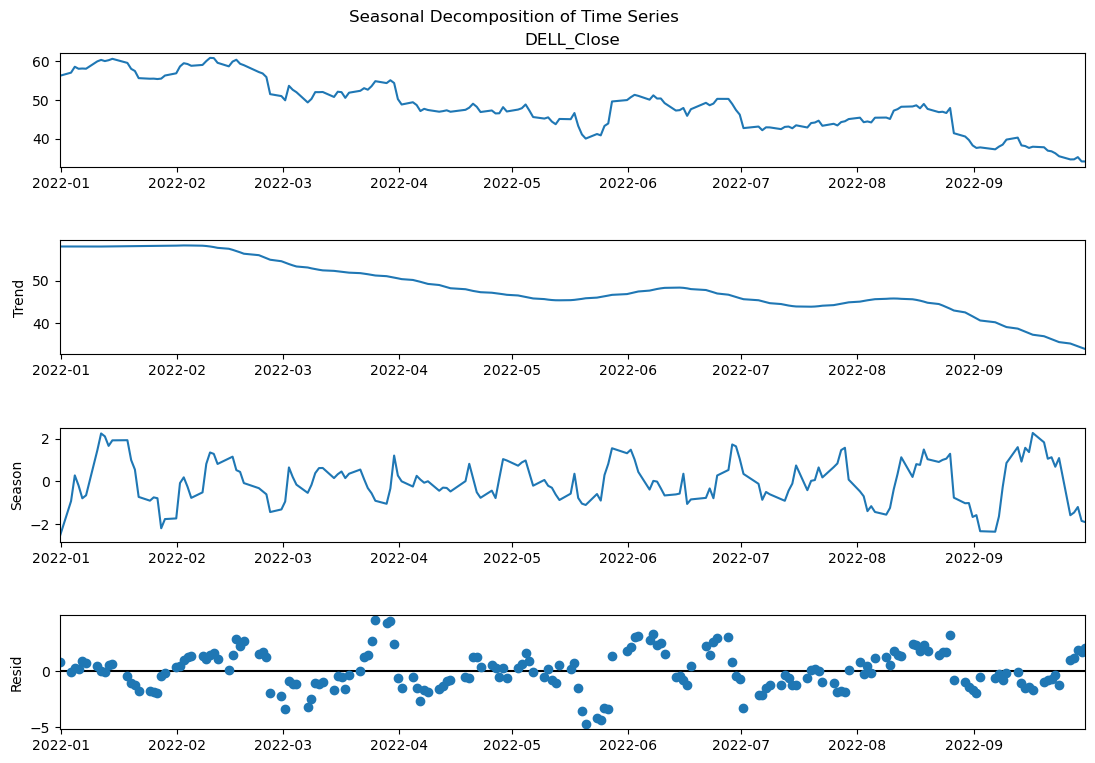

In [108]:
# Plot trend, seasonal, and residual components
fig = stl_result.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Time Series')
plt.show()

In [109]:
# Predict using the testing dataset
y_pred_test_stl = STLForecast(training_data['DELL_Close'],ARIMA, model_kwargs={"order": (2, 1, 0)}, period = 20 )
res = y_pred_test_stl.fit()
y_pred_test = res.forecast(len(testing_data))

y_pred_test



/Users/henryfeng/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/henryfeng/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/henryfeng/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/henryfeng/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

167    42.819102
168    43.441236
169    43.254126
170    43.070325
171    44.196523
172    44.173510
173    44.817149
174    44.337247
175    45.405601
176    45.365715
177    46.016122
178    44.862951
179    44.587777
180    44.309174
181    44.277171
182    44.888197
183    40.752966
184    39.714821
185    38.947373
186    38.155185
187    42.737405
dtype: float64

In [110]:
# Calculate Mean Squared Error on testing data
mse_test = mean_squared_error(testing_data['DELL_Close'], y_pred_test)
print("Mean Squared Error on September Testing Data:", mse_test)

Mean Squared Error on September Testing Data: 42.212181330708454


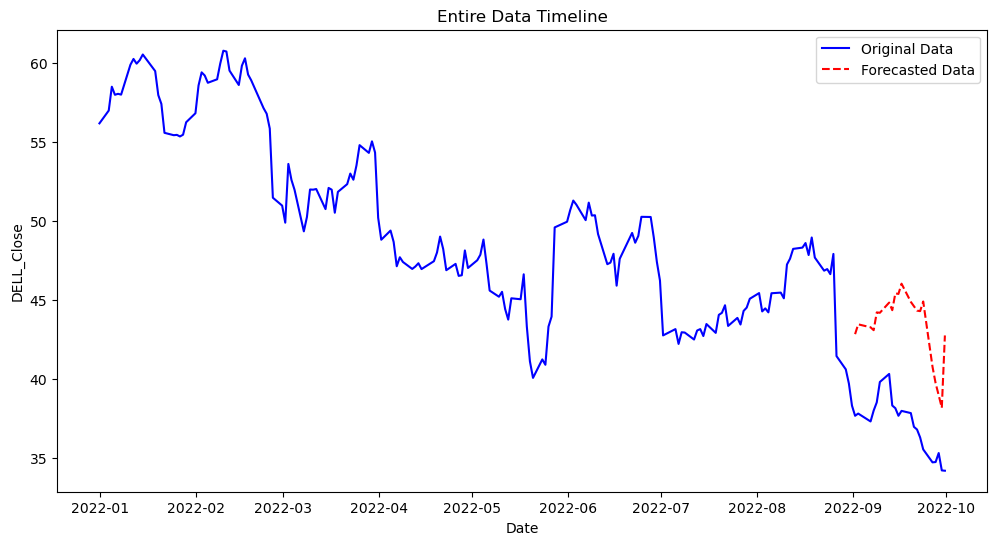

In [111]:
# Combine original and forecasted data for plotting
combined_data = pd.concat([df['DELL_Close'], pd.Series(y_pred_test, index=testing_data.index)], axis=0)

# Plot original and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data, label='Original Data', color='blue')
plt.plot(testing_data.index, y_pred_test, label='Forecasted Data', linestyle='--', color='red')
plt.title('Entire Data Timeline')
plt.xlabel('Date')
plt.ylabel('DELL_Close')
plt.legend()
plt.show()